<a href="https://colab.research.google.com/github/VictoKu1/API_Security_Research/blob/master/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cisco - Ariel University API Security Detection Challenge 2023


---



---



## Dataset 1 (Task 1)

The most basic API traffic containing the least number of attacks and endpoints. Will basically enable to have a soft start. 

```
Dataset 1 baseline score:

                   precision    recall  f1-score   support

    Benign          0.95715   0.93922   0.99792       480
    Malware         0.99799   0.94129   0.96881       528
    
    accuracy                            0.96825      1008
    macro avg       0.96860   0.96960   0.96824      1008
    weighted avg    0.97000   0.96825   0.96827      1008

```

[Link to the Dataset 1](https://drive.google.com/file/d/15MxHRAdwPXCENACwn8wLMkb98ZCjDeh6/view?usp=share_link)

## Baseline code

### Imports and global settings

In [1589]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.decomposition import TruncatedSVD

import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as ps
import matplotlib.pyplot as plt
import plotly.io as pio
pio.templates.default = "plotly_dark"
pio.templates['plotly_dark'].layout.autosize = False
pio.templates['plotly_dark'].layout.width = 1_000
pio.templates['plotly_dark'].layout.height = 800

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import pickle

# from ipywidgets import widgets
# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 1   # Options are [1, 2, 3, 4]
test_type = 'label'  # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df_org = pd.json_normalize(raw_ds, max_level=2)

# Copy data
df = df_org.copy()
print("Original Data:", df_org.shape,
      "\nCopy Data:", df.shape)

df.head()

Original Data: (4282, 25) 
Copy Data: (4282, 25)


,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,Directory Traversal,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,NaN,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,Cookie Injection,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,NaN,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,LOG4J,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [1590]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=wKm-iDQeCXGjwXGrGJvfzWzs5VYbnWSP75B6BjFz1...,"Mon, 21 Nov 2022 18:39:51 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,/cookielogin,0,username=gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc...,Cookie Injection,Malware
4278,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=oyXTP1KfNdMwWb_jIYEQYKzE9RZALsuCGCtJtUlju...,"Mon, 21 Nov 2022 18:39:51 GMT",GET,http://127.0.0.1:5000/orders/get/id/7668,,404 NOT FOUND,application/json,36,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
4279,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=bfYOeMnpxlFA9F7ObPemhCXYmeYNbBteewfAWbnfy...,"Mon, 21 Nov 2022 18:39:52 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyAAAAAAAAACMCGJ1aWx0aW5zlIw

### Preprocessing Data


In [1591]:
from collections import Counter
COLUMNS_TO_DROP = []

for col in df.columns:
    # More the 50% Null
    if df[col].isna().sum()/df.shape[0]*100 > 50:
        COLUMNS_TO_DROP.append(df[col])
        print(f"Column {col} has {df[col].isna().sum()} NaN values, "
              f"which is {round(df[col].isna().sum() / df.shape[0] * 100, 2)}%, "
              f"and has {df[col].nunique()} unique values")
        # df.drop([col], axis=1, inplace=True)

for col in df.columns:
    # All rows have the same value
    if len(Counter(df[col])) == 1:
        COLUMNS_TO_DROP.append(df[col])
        print(f"Column {col} has the same value for all rows")
        # df.drop([col], axis=1, inplace=True)

for col in df.columns[df.isna().any()].tolist():
    df[col] = df[col].fillna('None')

print("Deleted:", len(COLUMNS_TO_DROP), " New Shape:", df.shape)
df.head()

Column request.headers.Cookie has 3716 NaN values, which is 86.78%, and has 38 unique values
Column response.headers.Location has 3881 NaN values, which is 90.64%, and has 2 unique values
Column request.headers.Content-Length has 3983 NaN values, which is 93.02%, and has 1 unique values
Column response.headers.Set-Cookie has 3983 NaN values, which is 93.02%, and has 1 unique values
Column request.headers.Host has the same value for all rows
Column request.headers.Accept has the same value for all rows
Column request.headers.Connection has the same value for all rows
Column request.headers.Sec-Fetch-User has the same value for all rows
Column request.body has the same value for all rows
Deleted: 9  New Shape: (4282, 26)


,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,LOG4J,Malware


In [1592]:
# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                  # 'request.headers.Host',
                  'request.method',
                  'request.headers.Accept-Language',
                  'request.headers.Sec-Fetch-Site',
                  'request.headers.Sec-Fetch-Mode',
                  'request.headers.Sec-Fetch-Dest',
                  'response.status',
                  ]

# On these headers we will run HashingVector
COMPLEX_HEADERS = ['request.headers.User-Agent',
                   'request.headers.Set-Cookie',
                   'request.headers.Date',
                   'request.url',
                   'response.headers.Content-Type',
                   'response.body',
                   # 'response.headers.Location',
                   # 'request.headers.Content-Length',
                   # 'request.headers.Cookie',
                   # 'response.headers.Set-Cookie'
                   ]

COLUMNS_TO_REMOVE = ['request.body',
                     'response.headers.Content-Length',
                     'request.headers.Date',
                     'request.headers.Accept', ###
                     'request.headers.Connection', ###
                     'request.headers.Sec-Fetch-User', ###
                     'request.headers.Cookie', #
                     'response.headers.Location', #
                     'request.headers.Content-Length', #
                     'response.headers.Set-Cookie', #
                     'request.headers.Host', ##
                     ]

def vector_df(df_):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=8)

    # Run LabelEncoder on the chosen features
    for j in SIMPLE_HEADERS:
        print("1", j)
        df_[j] = le.fit_transform(df_[j])

    # Run HashingVectorized on the chosen features
    for j in COMPLEX_HEADERS:
        print("2", j)
        newHVec = h_vec.fit_transform(df_[j])
        df_[j] = newHVec.todense()

    # Remove cols
    for j in COLUMNS_TO_REMOVE:
        print("3", j)
        df_.drop(j, axis=1, inplace=True)

    return df_

df = vector_df(df)
print("Vector_df:", df.shape)
df.head()

1 request.headers.Accept-Encoding
1 request.method
1 request.headers.Accept-Language
1 request.headers.Sec-Fetch-Site
1 request.headers.Sec-Fetch-Mode
1 request.headers.Sec-Fetch-Dest
1 response.status
2 request.headers.User-Agent
2 request.headers.Set-Cookie
2 request.headers.Date
2 request.url
2 response.headers.Content-Type
2 response.body
3 request.body
3 response.headers.Content-Length
3 request.headers.Date
3 request.headers.Accept
3 request.headers.Connection
3 request.headers.Sec-Fetch-User
3 request.headers.Cookie
3 response.headers.Location
3 request.headers.Content-Length
3 response.headers.Set-Cookie
3 request.headers.Host
Vector_df: (4282, 15)


,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,attack_type,label
0,-0.408248,0,1,0,0,0,-0.777778,0,0.000000,0,0.0,200,0.000000,Directory Traversal,Malware
1,-0.316228,0,0,0,0,0,-0.693688,0,-0.377964,4,0.0,404,-0.447214,Benign,Benign
2,-0.774597,0,0,0,0,0,-0.759326,0,0.000000,0,-0.5,200,0.000000,Cookie Injection,Malware
3,0.000000,0,1,0,0,0,-0.693103,0,0.577350,4,0.0,404,0.000000,Benign,Benign
4,0.000000,0,0,0,0,29,-0.792118,0,-0.377964,4,0.0,404,-0.447214,LOG4J,Malware


In [1593]:
# Choose features
features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')

print(features_list)

# Check type
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.status_code', 'response.body']


request.headers.User-Agent         float64
request.headers.Accept-Encoding      int32
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.method                       int32
request.url                        float64
response.status                      int32
response.headers.Content-Type      float64
response.status_code                 int64
response.body                      float64
attack_type                         object
label                               object
dtype: object

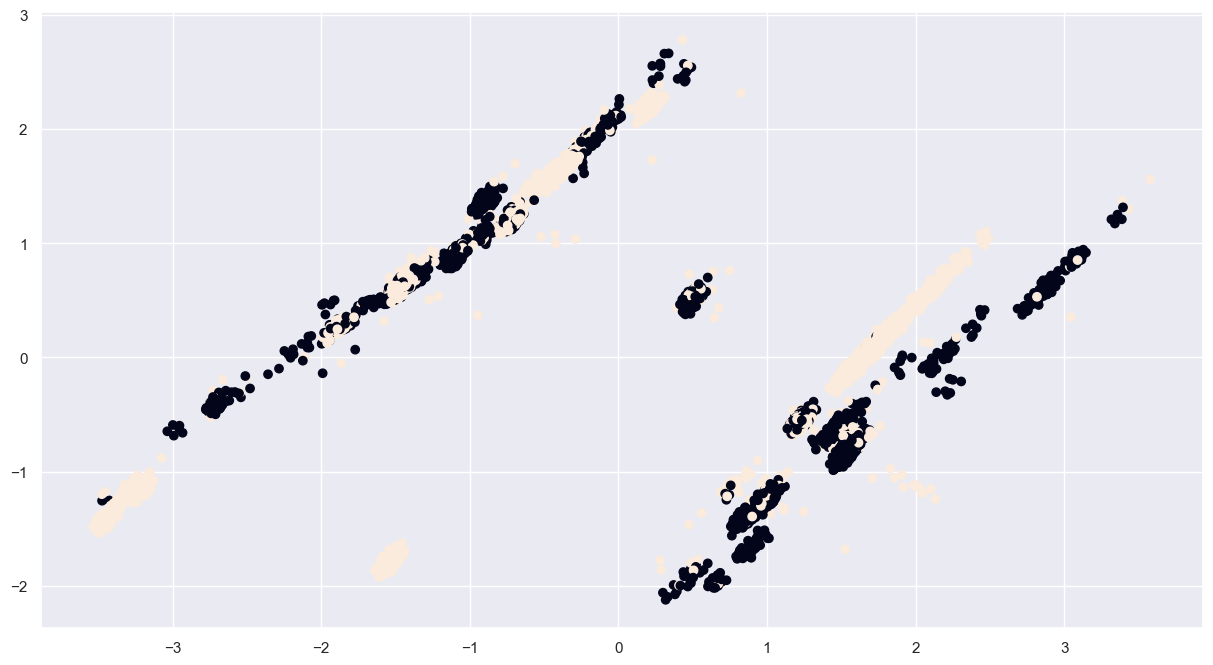

In [1594]:
ss = StandardScaler()
pca = PCA(n_components=2)
x_after_pca_in_2D = pca.fit_transform(ss.fit_transform(df[features_list].to_numpy()))

plt.scatter(x_after_pca_in_2D[:, 0],
            x_after_pca_in_2D[:, 1],
            c=df['label'].map({'Benign': 0, 'Malware': 1}))

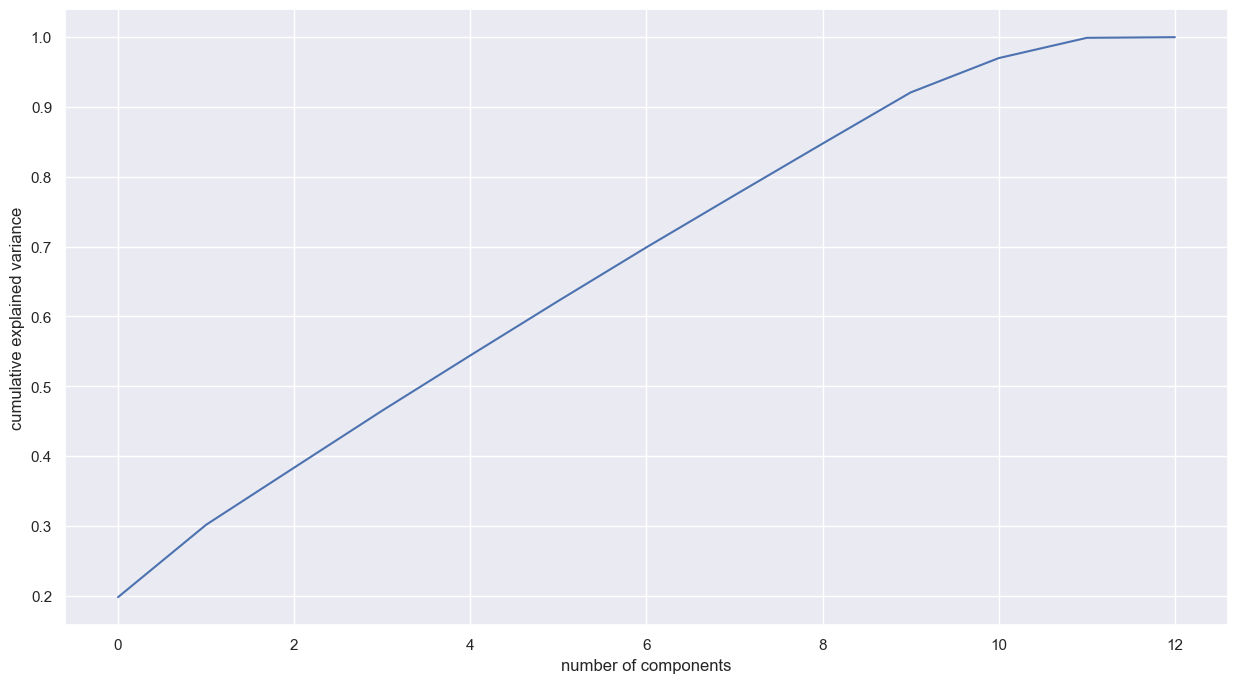

In [1595]:
pca = PCA()
pca.fit(ss.fit_transform(df[features_list].to_numpy()))
pca_exp_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


As we can see we can compress the data into X components without losing any information.

## Train Test Split

*   x_Train and y_Train will be used for _Train_
*   x_test and y_test.T will be used for _Test_


In [1596]:
# Convert the feature list to a numpy array
x = df[features_list]

# This column is the desired prediction we'll use to train our model
y = np.stack(df[test_type])

# Split the dataset to train and test
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.1765, 
                                                    random_state=42, 
                                                    stratify=y)

# Print the resulted datasets 
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Count differences
counter = Counter(y)
counter

(3526, 13) (3526,)
(756, 13) (756,)


Counter({'Malware': 2264, 'Benign': 2018})

In [1597]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

pca = PCA(n_components=8)
pca.fit(x_train)

x_train_pca = x_train
x_train_pca_ = pca.transform(x_train)

x_test_pca = x_test
x_test_pca_ = pca.transform(x_test)


In [1598]:
def plot_feature_importance(model):
    plt.figure(figsize=(10, 10))
    plt.title("Feature importance")
    plt.barh(range(x_train_pca.shape[1]), model.feature_importances_, align="center")
    plt.yticks(np.arange(x_train_pca.shape[1]), features_list)
    plt.ylim([-1, x_train_pca.shape[1]])
    plt.show()

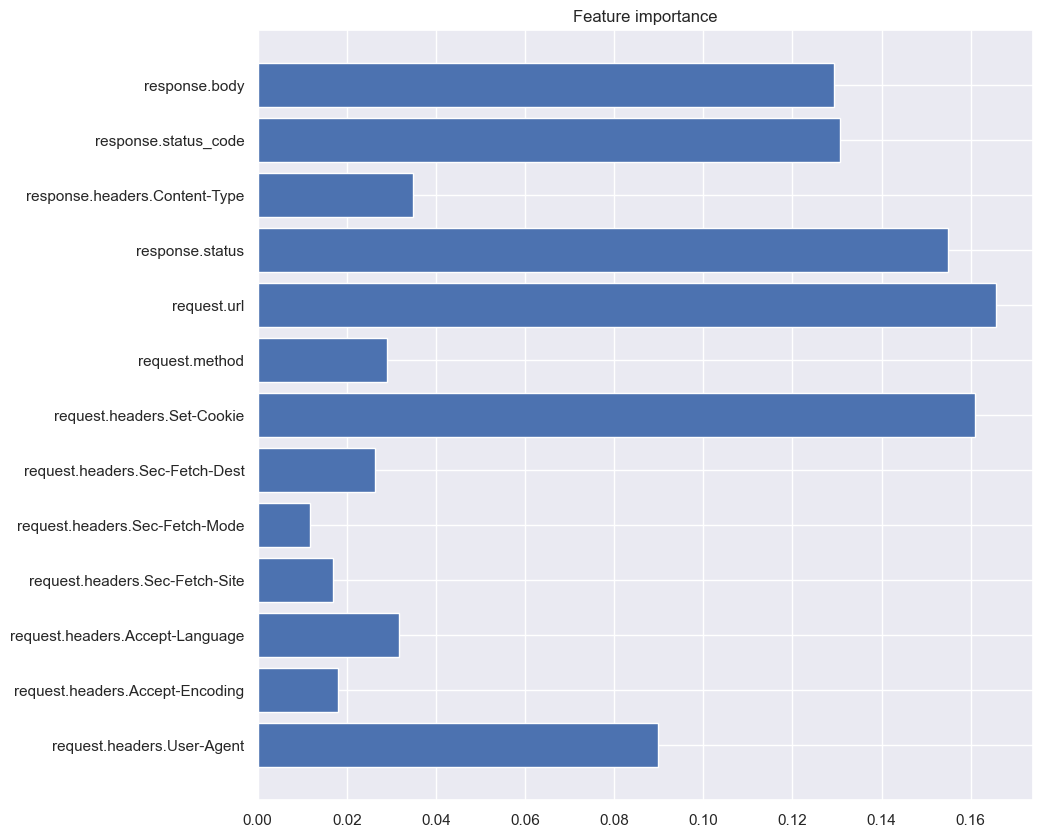

In [1599]:
# Feature selection with Random Forest Classifier
rfc_fs = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_fs.fit(x_train, y_train)

# Plot the feature importance of the forest
plot_feature_importance(rfc_fs)

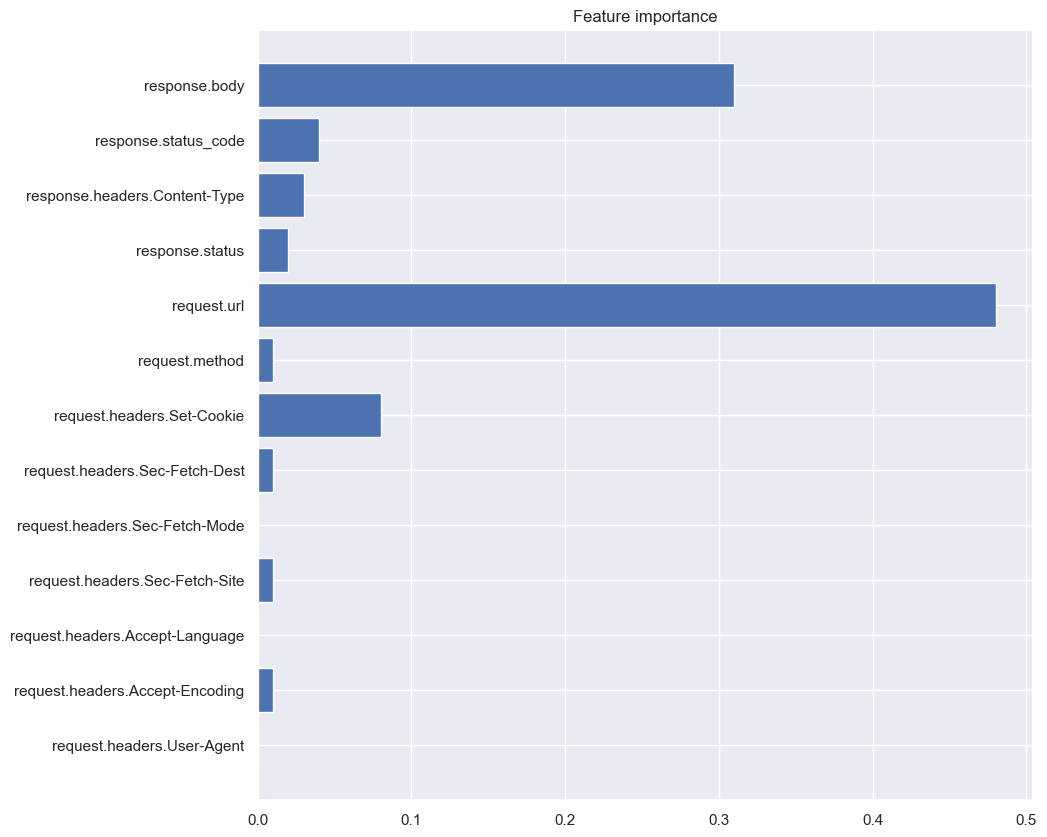

In [1600]:
# Feature selection with AdaBoost Classifier
abc_fs = AdaBoostClassifier(n_estimators=100, random_state=42)
abc_fs.fit(x_train, y_train)

# Plot the feature importance of the forest
plot_feature_importance(abc_fs)

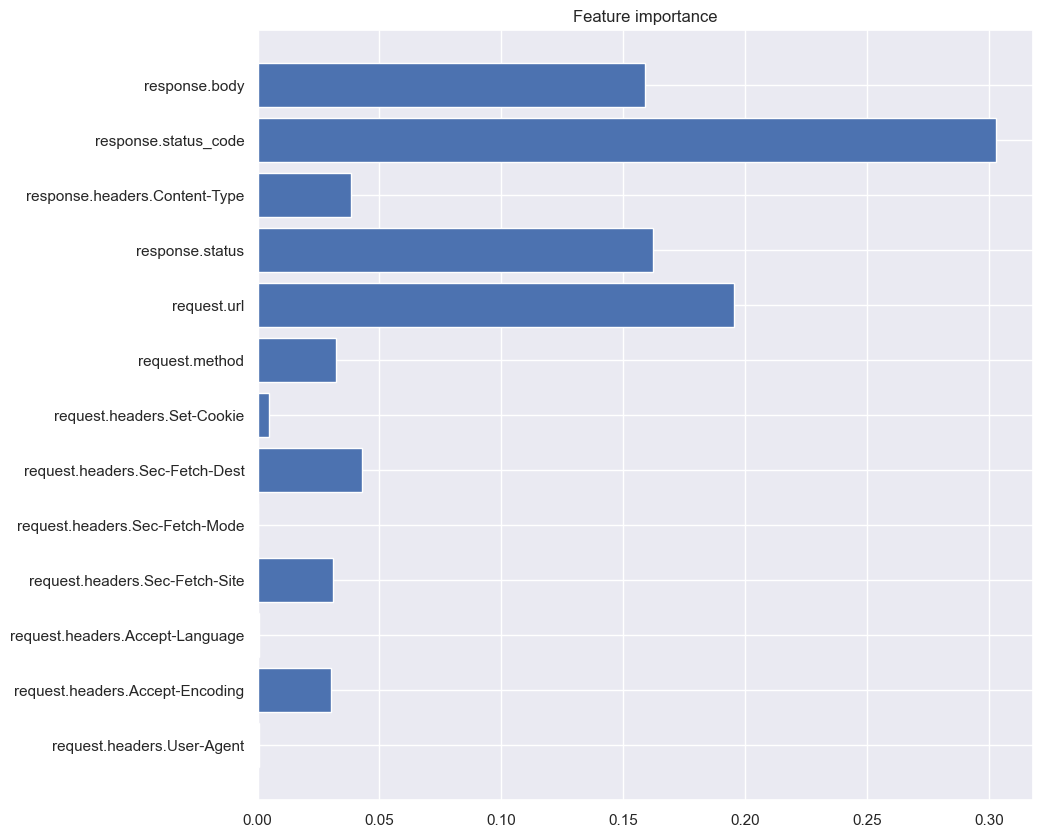

In [1601]:
# Feature selection with Gradient Boosting Classifier
gbc_fs = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc_fs.fit(x_train, y_train)

# Plot the feature importance of the forest
plot_feature_importance(gbc_fs)

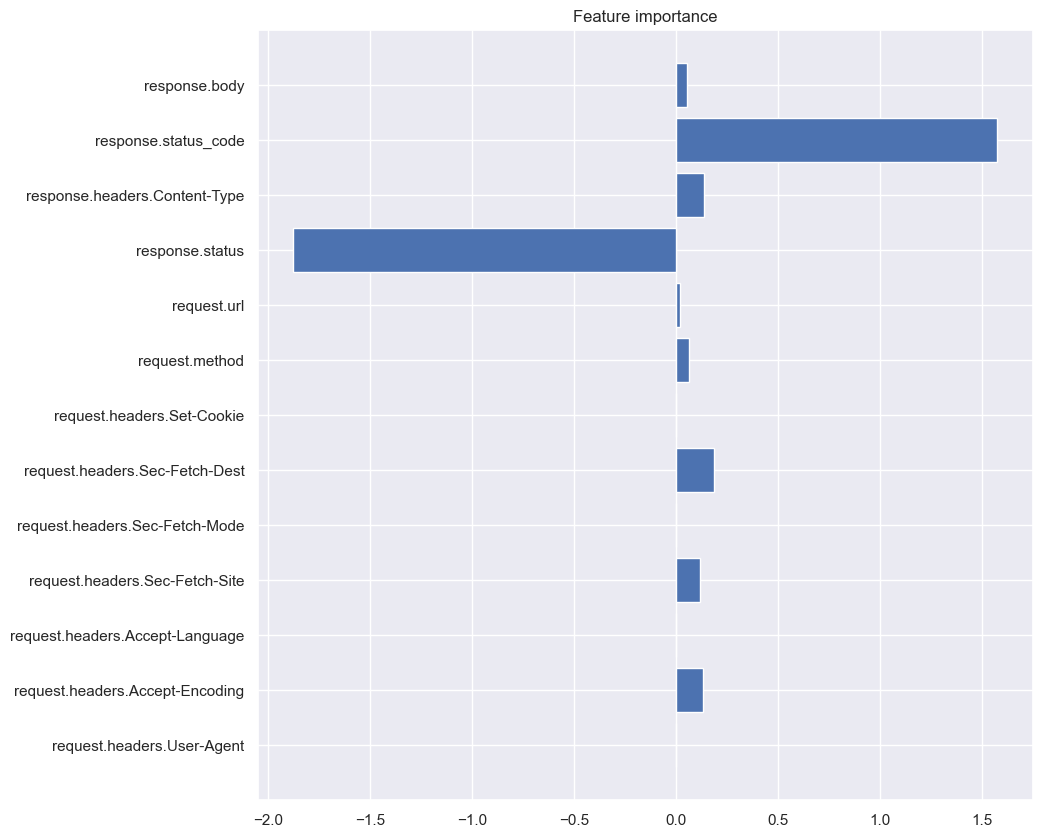

In [1602]:
from sklearn.svm import LinearSVC

# Feature importance with Linear SVC
linear_svc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(x_train_pca, y_train)
var = linear_svc.coef_

# Plot feature importance with Linear SVC
plt.figure(figsize=(10, 10))
plt.title("Feature importance")
plt.barh(range(x_train.shape[1]), linear_svc.coef_[0], align="center")
plt.yticks(np.arange(x_train.shape[1]), features_list)
plt.ylim([-1, x_train.shape[1]])
plt.show()

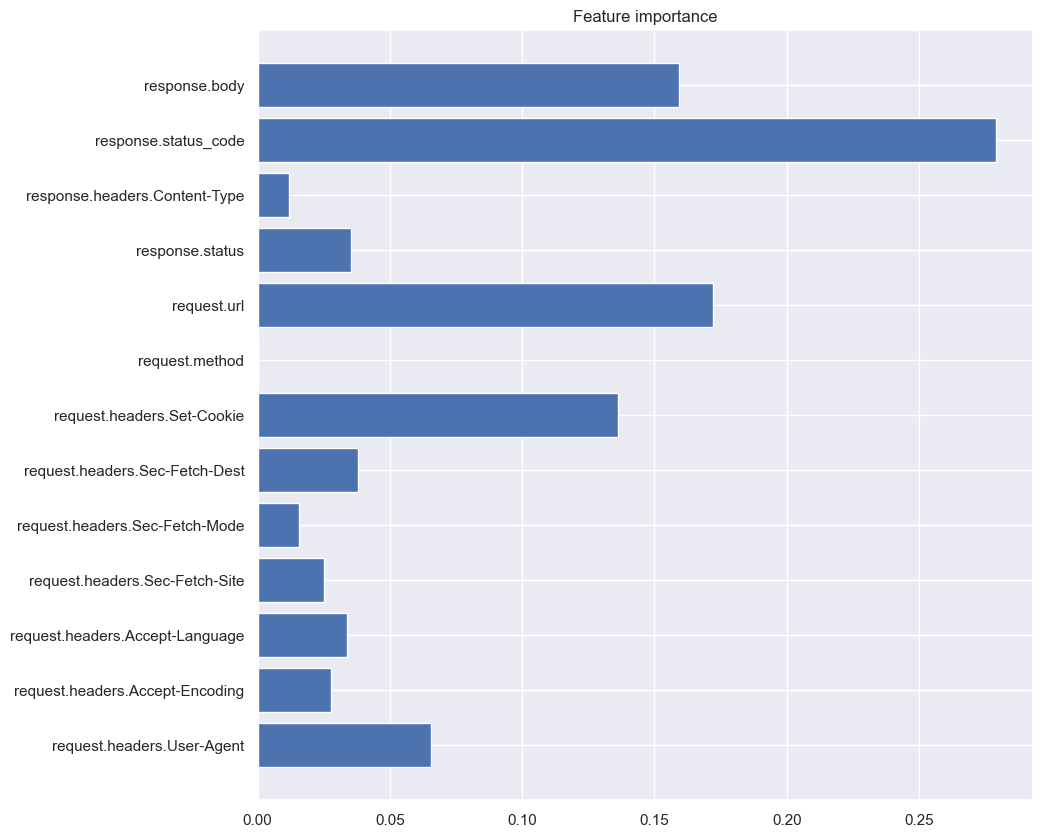

In [1603]:
# Feature selection with Decision Tree Classifier
dtc_fs = DecisionTreeClassifier(random_state=42)
dtc_fs.fit(x_train, y_train)

plot_feature_importance(dtc_fs)

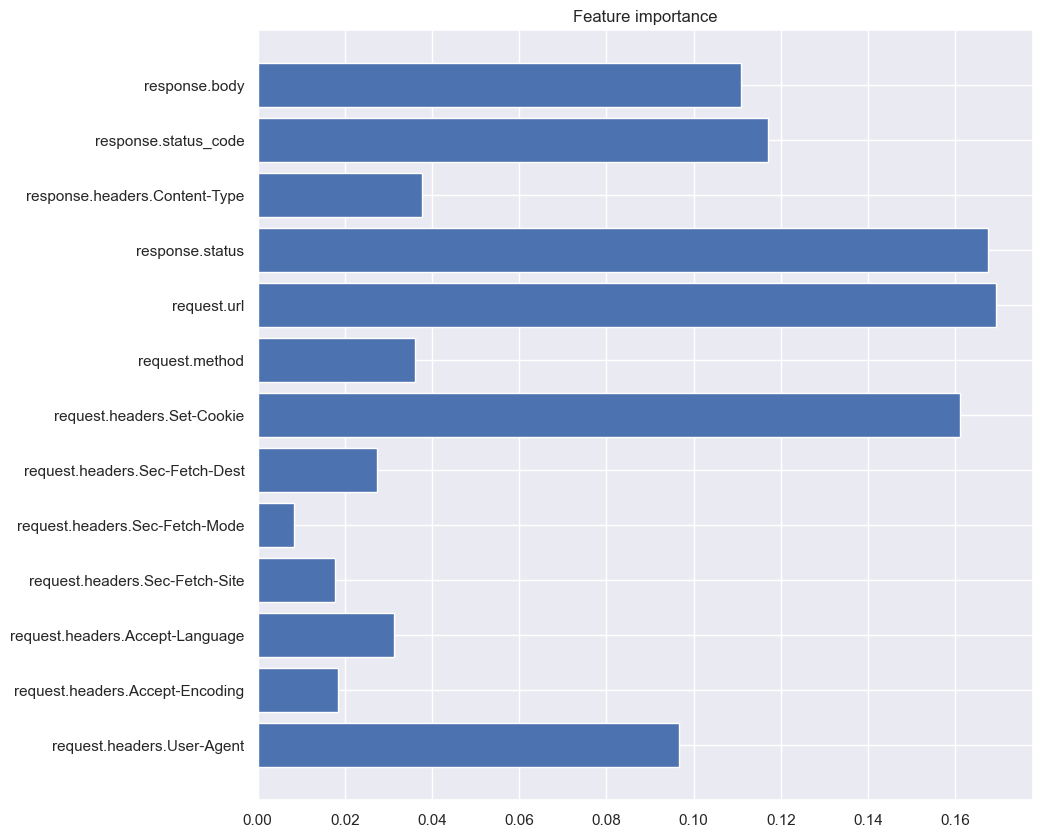

In [1604]:
from sklearn.ensemble import ExtraTreesClassifier

# Feature selection with Extra Trees Classifier
etc_fs = ExtraTreesClassifier(n_estimators=100, random_state=42)
etc_fs.fit(x_train, y_train)

plot_feature_importance(etc_fs)

In [1605]:
# Print top 10 feature ranking
fs_table = pd.DataFrame(columns=['Feature',
                                 'Random Forest',
                                 'AdaBoost',
                                 'Gradient Boosting',
                                 'Linear SVC',
                                 'Decision Tree',
                                 'Extra Trees'])
fs_table['Feature'] = features_list
fs_table['Random Forest'] = rfc_fs.feature_importances_
fs_table['AdaBoost'] = abc_fs.feature_importances_
fs_table['Gradient Boosting'] = gbc_fs.feature_importances_
fs_table['Linear SVC'] = np.abs(linear_svc.coef_[0])
fs_table['Decision Tree'] = dtc_fs.feature_importances_
fs_table['Extra Trees'] = etc_fs.feature_importances_
fs_table['Mean'] = fs_table.mean(axis=1)
fs_table.sort_values(by='Mean', ascending=False, inplace=True)
fs_table.head(10)

C:\Users\moria\AppData\Local\Temp\ipykernel_3336\772953842.py:16: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Feature,Random Forest,AdaBoost,Gradient Boosting,Linear SVC,Decision Tree,Extra Trees,Mean
11,response.status_code,0.130742,0.04,0.302792,1.576404,0.278968,0.117142,0.407675
9,response.status,0.154828,0.02,0.162420,1.880643,0.035440,0.167509,0.403473
8,request.url,0.165614,0.48,0.195502,0.019655,0.172277,0.169297,0.200391
12,response.body,0.129315,0.31,0.158896,0.052718,0.159421,0.110996,0.153557
6,request.headers.Set-Cookie,0.160983,0.08,0.004498,0.000000,0.136256,0.161071,0.090468
5,request.headers.Sec-Fetch-Dest,0.026396,0.01,0.043011,0.185357,0.037878,0.027494,0.055023
10,response.headers.Content-Type,0.034845,0.03,0.038460,0.137894,0.011958,0.037774,0.048488
0,request.headers.User-Agent,0.089867,0.00,0.000472,0.000000,0.065467,0.096569,0.042063
1,request.headers.Accept-Encoding,0.017980,0.01,0.030202,0.130477,0.027846,0.018409,0.039152
3,request.headers.Sec-Fetch-Site,0.017000,0.01,0.030913,0.116592,0.025271,0.017865,0.036273


Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Optimal number of features: 8
(3526, 8)


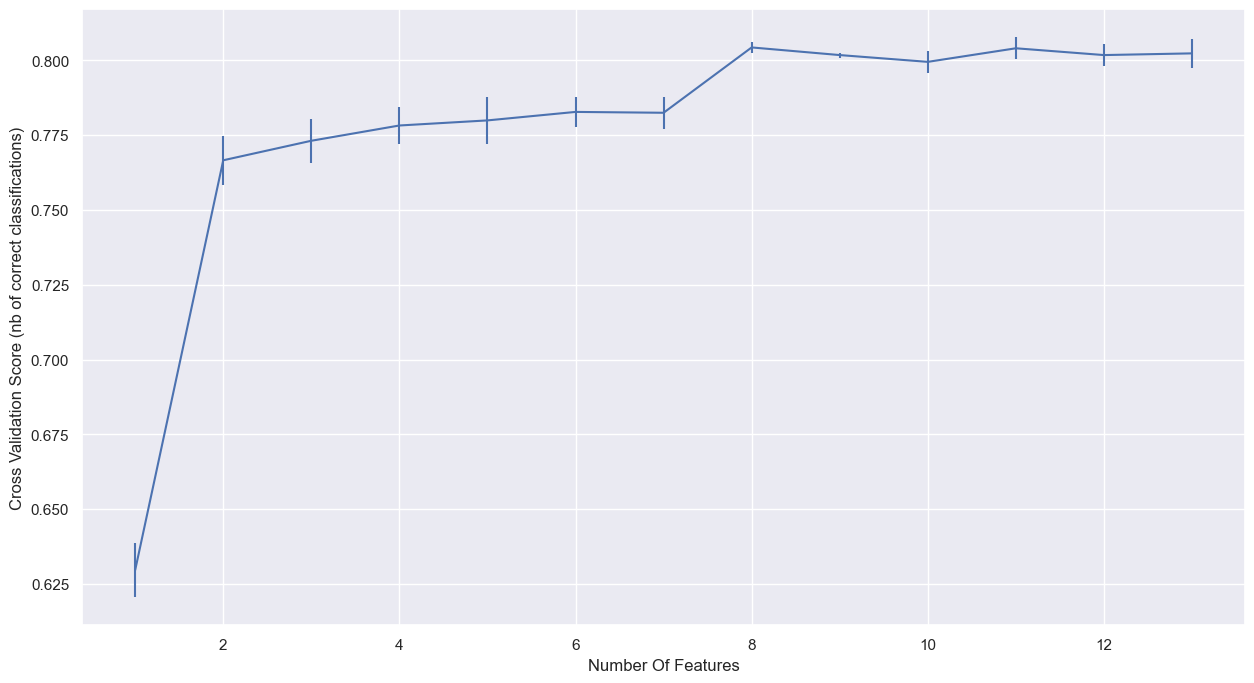

In [1606]:
# Feature selection

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Create the RFE object and compute a cross-validated score
recall_scorer = make_scorer(recall_score, pos_label='Malware')
rfecv = RFECV(estimator=LogisticRegression(),
              step=1,
              cv=StratifiedKFold(2),
              # scoring=recall_scorer,
              verbose=3,
              n_jobs=-1)
rfecv.fit(x_train_pca, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number Of Features")
plt.ylabel("Cross Validation Score (nb of correct classifications)")
plt.errorbar(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
             rfecv.cv_results_["mean_test_score"],
             yerr=rfecv.cv_results_["std_test_score"])
plt.show()

x_train_pca = rfecv.transform(x_train_pca)
x_test_pca = rfecv.transform(x_test_pca)

print(x_train_pca.shape)

In [1607]:
# Grid search to find the best hyperParameters for the model
def create_grid_search(model, params):
    return GridSearchCV(estimator=model,
                        param_grid=params,
                        # scoring=recall_scorer,
                        n_jobs=-1,
                        cv=3,
                        verbose=3,
                        return_train_score=True)

In [1608]:
def model_report_presentation(model):
    # We print our results
    sns.set(rc={'figure.figsize': (15, 8)})
    pred = model.predict(x_test_pca)
    true_labels = y_test
    cf_matrix = confusion_matrix(true_labels, pred)
    report_model = classification_report(true_labels, pred, digits=5)
    heatmap = sns.heatmap(cf_matrix,
                          annot=True,
                          cmap='Blues',
                          fmt='g',
                          xticklabels=np.unique(true_labels),
                          yticklabels=np.unique(true_labels))

    # The heatmap is cool but this is the most important result
    print(report_model)

### Model Choosing & Fitting


#### Random Forest

Ensemble learning method that uses multiple decision trees to make predictions. 
It is a robust and flexible model that can handle high-dimensional and complex data,making it a good choice for API classification tasks.

In [1609]:
rf = RandomForestClassifier()
rf_param = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3, 5],
}
rf_gcv = create_grid_search(rf, rf_param)
rf_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5]},
             return_train_score=True, verbose=3)

In [1610]:
print("Best parameters:", rf_gcv.best_params_)

Best parameters: {'criterion': 'gini', 'max_depth': 5}


              precision    recall  f1-score   support

      Benign    0.95708   0.62640   0.75722       356
     Malware    0.74570   0.97500   0.84507       400

    accuracy                        0.81085       756
   macro avg    0.85139   0.80070   0.80114       756
weighted avg    0.84524   0.81085   0.80370       756



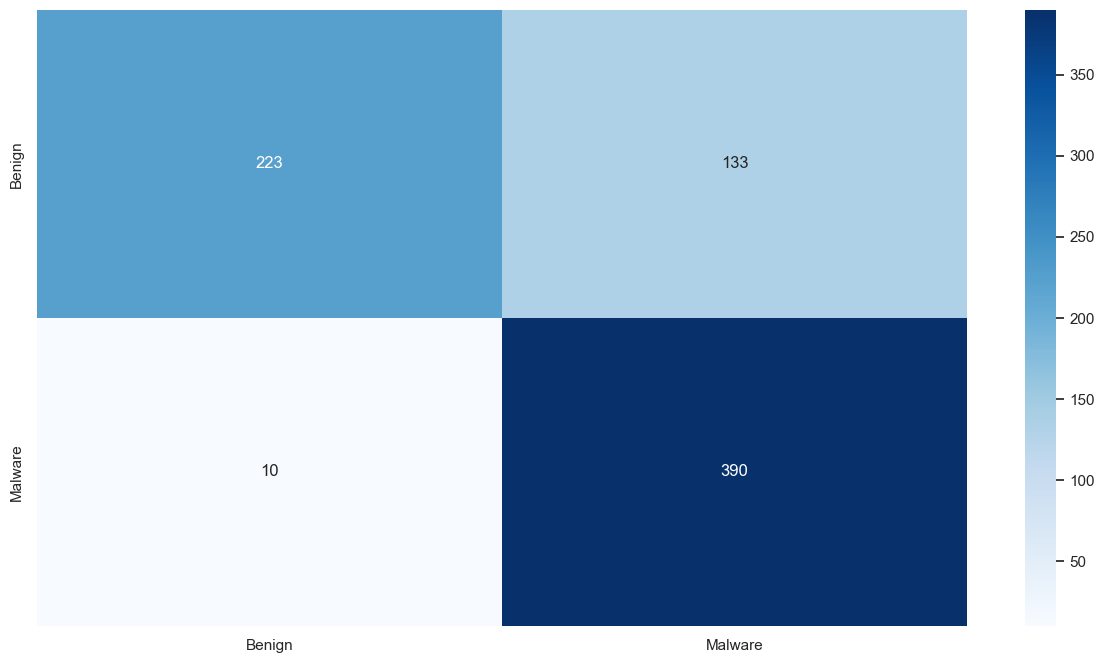

In [1611]:
model_report_presentation(rf_gcv)

In [1612]:
# # Save the model
clf = rf_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/rf"+str(dataset_number)+"_model.sav"
# pickle.dump(clf, open(filename, 'wb'))

#### SVM - Support Vector Machines 

Popular choice for classification tasks, including API classification. 
They work by finding the hyperplane in a high-dimensional space that maximally separates different classes of data points.

In [1613]:
svc = SVC(cache_size=500)
svc_param = {
    "C": [1, 2, 3],
    "kernel": ["poly", "rbf", "sigmoid"],
    "probability": [True],
}
svc_gcv = create_grid_search(svc, svc_param)
svc_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=SVC(cache_size=500), n_jobs=-1,
             param_grid={'C': [1, 2, 3], 'kernel': ['poly', 'rbf', 'sigmoid'],
                         'probability': [True]},
             return_train_score=True, verbose=3)

In [1614]:
print("Best parameters:", svc_gcv.best_params_)

Best parameters: {'C': 2, 'kernel': 'rbf', 'probability': True}


              precision    recall  f1-score   support

      Benign    0.77033   0.90449   0.83204       356
     Malware    0.89941   0.76000   0.82385       400

    accuracy                        0.82804       756
   macro avg    0.83487   0.83225   0.82794       756
weighted avg    0.83863   0.82804   0.82771       756



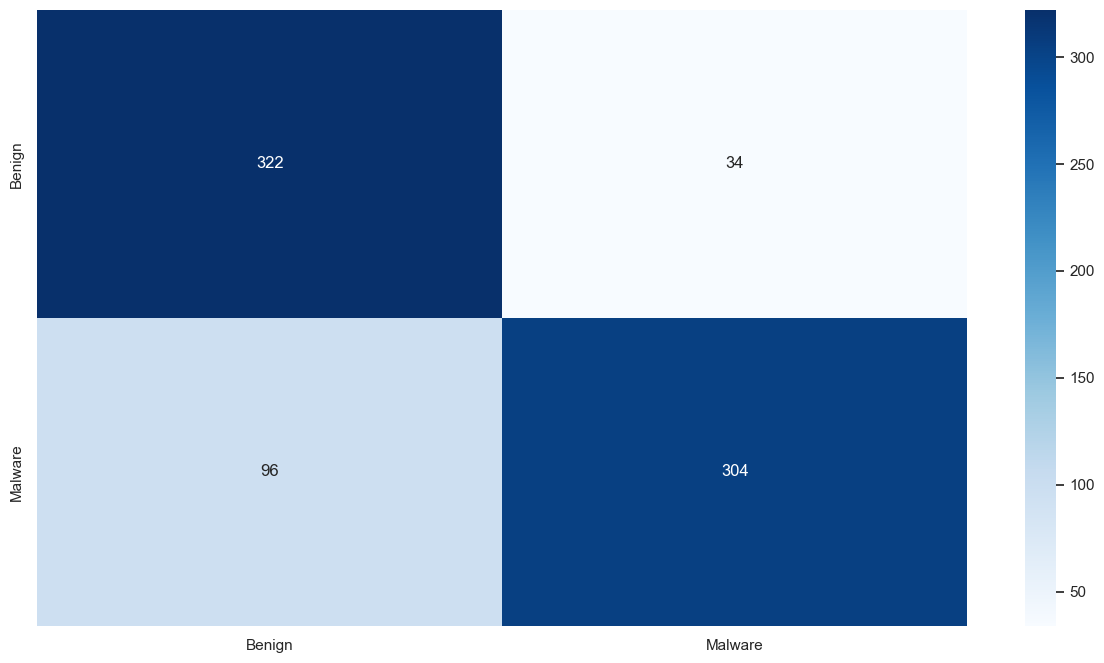

In [1615]:
model_report_presentation(svc_gcv)


In [1616]:
# # Save the model
svc = svc_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/svc"+str(dataset_number)+"_model.sav"
# pickle.dump(svc, open(filename, 'wb'))

#### Logistic Regression

Simple yet effective linear model for classification tasks. 
It is particularly useful for predicting binary outcomes (e.g., malicious vs benign) and is often used as a baseline model for comparison with more complex models.

In [1617]:
lr = LogisticRegression()
lr_param = {
    "C": [1, 2, 3, 4, 5],
    "penalty": ["none", "l2"],
}
lr_gcv = create_grid_search(lr, lr_param)
lr_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\moria\PycharmProjects\API_Security_Research\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 2, 3, 4, 5], 'penalty': ['none', 'l2']},
             return_train_score=True, verbose=3)

In [1618]:
print("Best parameters:", lr_gcv.best_params_)

Best parameters: {'C': 1, 'penalty': 'none'}


              precision    recall  f1-score   support

      Benign    0.95745   0.63202   0.76142       356
     Malware    0.74856   0.97500   0.84691       400

    accuracy                        0.81349       756
   macro avg    0.85300   0.80351   0.80416       756
weighted avg    0.84692   0.81349   0.80665       756



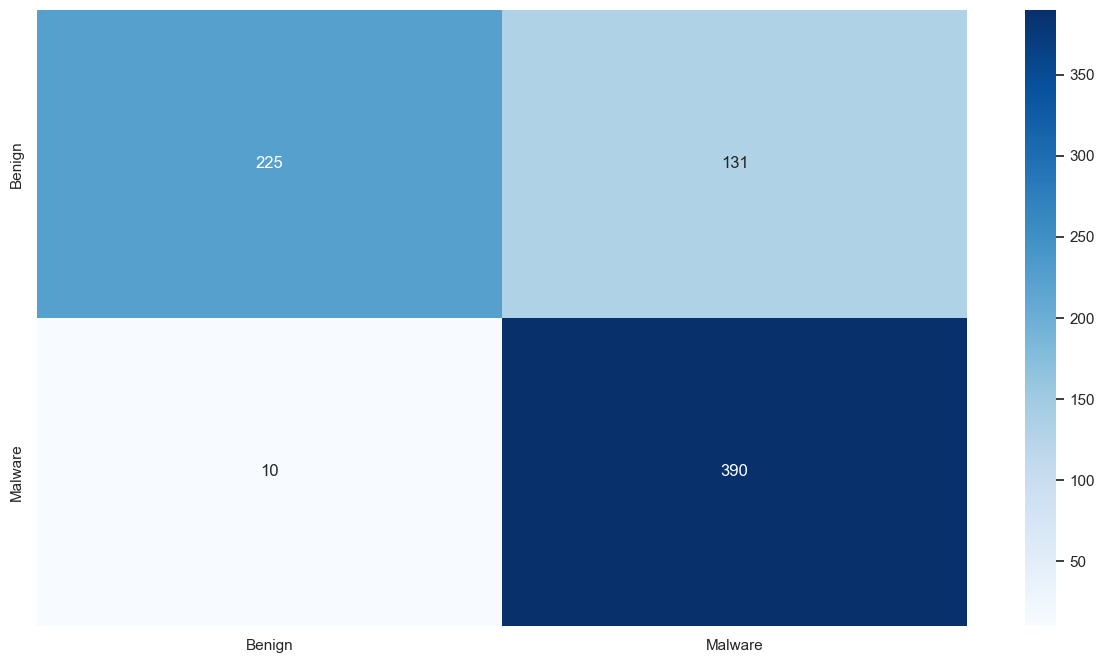

In [1619]:
model_report_presentation(lr_gcv)

In [1620]:
# # Save the model
lr = lr_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/lr"+str(dataset_number)+"_model.sav"
# pickle.dump(lr, open(filename, 'wb'))

#### KNN

Simple yet effective classification algorithm that works by finding the k nearest neighbors of a data point.
It is a non-parametric model that does not make any assumptions about the underlying data distribution.


In [1621]:
knn = KNeighborsClassifier()
knn_param = {
    "n_neighbors": [3, 5, 9, 13],
    "weights": ["uniform", "distance"],
}
knn_gcv = create_grid_search(knn, knn_param)
knn_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 9, 13],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, verbose=3)

In [1622]:
print("Best parameters:", knn_gcv.best_params_)

Best parameters: {'n_neighbors': 3, 'weights': 'distance'}


              precision    recall  f1-score   support

      Benign    0.86120   0.76685   0.81129       356
     Malware    0.81093   0.89000   0.84863       400

    accuracy                        0.83201       756
   macro avg    0.83607   0.82843   0.82996       756
weighted avg    0.83460   0.83201   0.83105       756



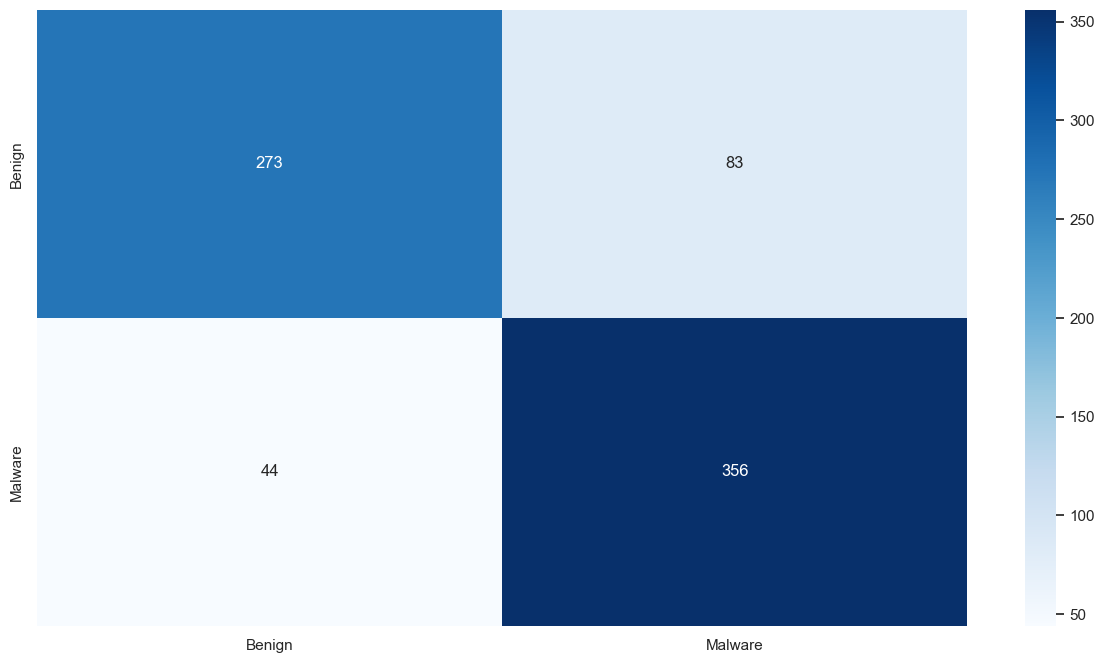

In [1623]:
model_report_presentation(knn_gcv)

In [1624]:
# # Save the model
knn = knn_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/knn"+str(dataset_number)+"_model.sav"
# pickle.dump(knn, open(filename, 'wb'))

#### Decision Trees

Popular choice for classification tasks.
They work by recursively partitioning the feature space into smaller and smaller regions, until each region contains only a single class of data points.


In [1625]:
dt = DecisionTreeClassifier()
dt_param = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 7, 9],
}
dt_gcv = create_grid_search(dt, dt_param)
dt_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 9]},
             return_train_score=True, verbose=3)

In [1626]:
print("Best parameters:", dt_gcv.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': 9}


              precision    recall  f1-score   support

      Benign    0.76623   0.99438   0.86553       356
     Malware    0.99320   0.73000   0.84150       400

    accuracy                        0.85450       756
   macro avg    0.87972   0.86219   0.85351       756
weighted avg    0.88632   0.85450   0.85281       756



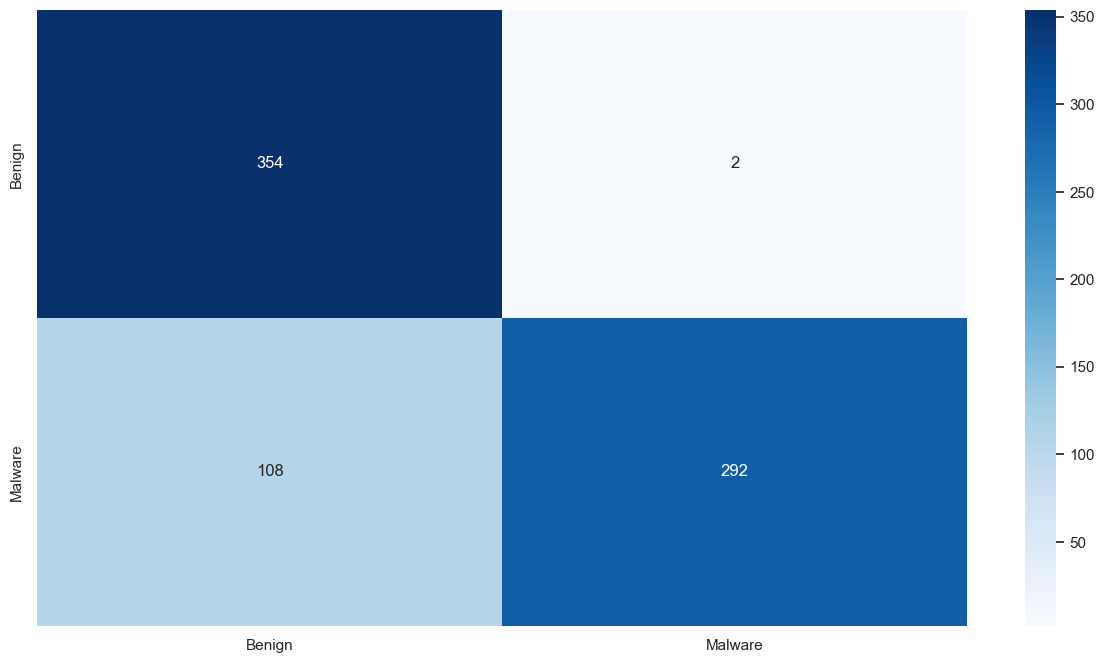

In [1627]:
model_report_presentation(dt_gcv)

In [1628]:
# # Save the model
dt = dt_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/dt"+str(dataset_number)+"_model.sav"
# pickle.dump(dt, open(filename, 'wb'))

#### AdaBoost

Popular ensemble method that works by combining the predictions of multiple weak learners.
It is a simple way to improve the performance of a model by combining the predictions of multiple models.

In [1629]:
abc = AdaBoostClassifier()
abc_param = {
    "n_estimators": [3, 5, 10],
    "learning_rate": [1, 100, 1000],
}
abc_gcv = create_grid_search(abc, abc_param)
abc_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [1, 100, 1000],
                         'n_estimators': [3, 5, 10]},
             return_train_score=True, verbose=3)

In [1630]:
print("Best parameters:", abc_gcv.best_params_)

Best parameters: {'learning_rate': 1, 'n_estimators': 10}


              precision    recall  f1-score   support

      Benign    0.81214   0.78933   0.80057       356
     Malware    0.81707   0.83750   0.82716       400

    accuracy                        0.81481       756
   macro avg    0.81461   0.81341   0.81387       756
weighted avg    0.81475   0.81481   0.81464       756



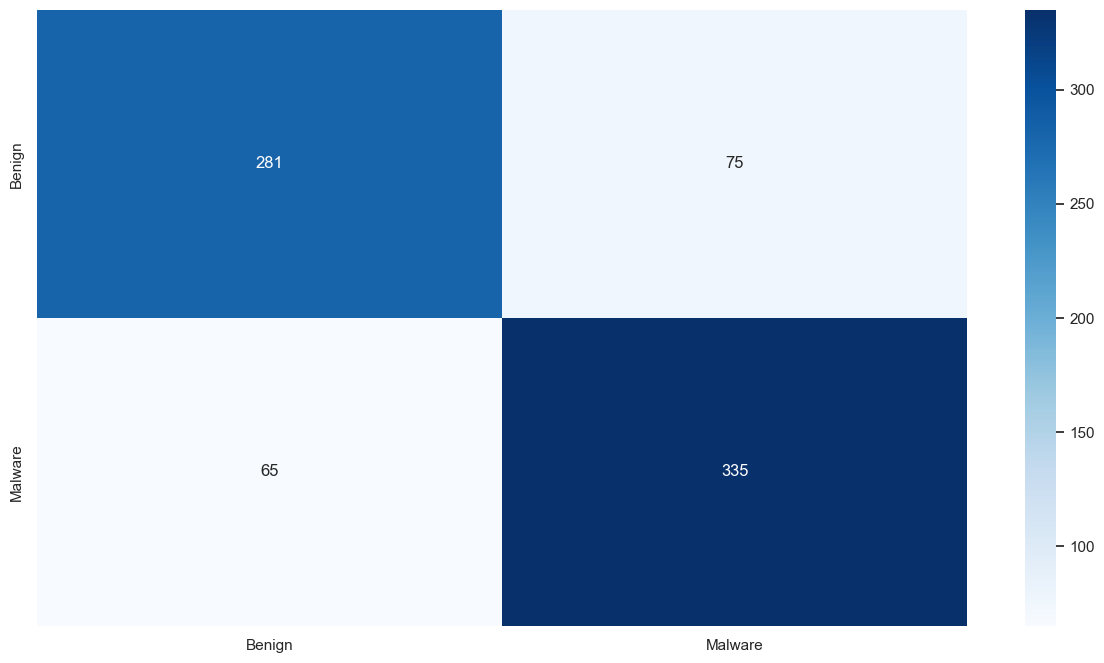

In [1631]:
model_report_presentation(abc_gcv)

In [1632]:
# # Save the model
abc = abc_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/abc"+str(dataset_number)+"_model.sav"
# pickle.dump(abc, open(filename, 'wb'))


#### Gradient Boosting

Popular ensemble method that works by combining the predictions of multiple weak learners.
It is a simple way to improve the performance of a model by combining the predictions of multiple models.


In [1633]:
gbc = GradientBoostingClassifier()
gbc_param = {
    "n_estimators": [3, 5, 10],
    "learning_rate": [0.001, 0.1],
}
gbc_gcv = create_grid_search(gbc, gbc_param)
gbc_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.1],
                         'n_estimators': [3, 5, 10]},
             return_train_score=True, verbose=3)

In [1634]:
print("Best parameters:", gbc_gcv.best_params_)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 5}


              precision    recall  f1-score   support

      Benign    0.95319   0.62921   0.75804       356
     Malware    0.74664   0.97250   0.84473       400

    accuracy                        0.81085       756
   macro avg    0.84992   0.80086   0.80139       756
weighted avg    0.84391   0.81085   0.80391       756



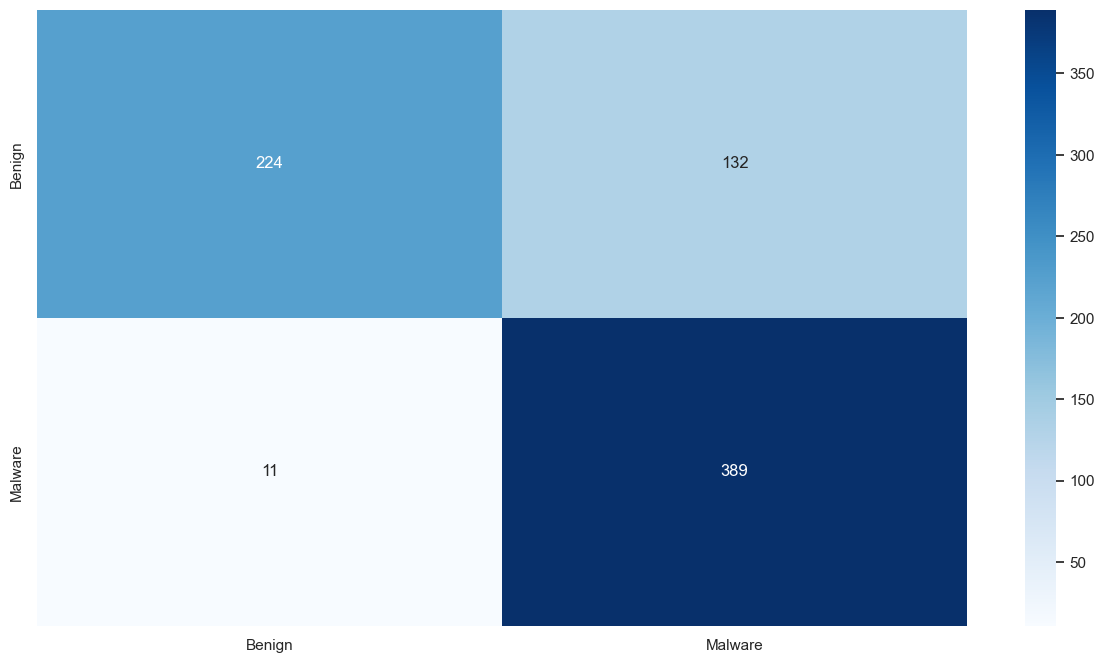

In [1635]:
model_report_presentation(gbc_gcv)

In [1636]:
# # Save the model
gbc = gbc_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/gbc"+str(dataset_number)+"_model.sav"
# pickle.dump(gbc, open(filename, 'wb'))

#### Neural Networks

popular choice for classification tasks.
They work by learning the weights of the connections between neurons in the network.

In [1637]:
mlp = MLPClassifier()
mlp_param = {
    "hidden_layer_sizes": [(10, 50, 100, 150, 100, 50, 10),
                           (10, 50, 100, 150, 200, 150, 100, 50, 10),
                           (10, 50, 100, 150, 200, 250, 200, 150, 100, 50, 10),
                           ],
    "activation": ["relu", "logistic"],
    "solver": ["adam", "sgd"],
    "batch_size": [8, 16, 48],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "shuffle": [False],
    "early_stopping": [True],
}
mlp_gcv = create_grid_search(mlp, mlp_param)
mlp_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'batch_size': [25, 50, 75], 'early_stopping': [True],
                         'hidden_layer_sizes': [(10, 50, 100, 150, 100, 50, 10),
                                                (10, 50, 100, 150, 200, 150,
                                                 100, 50, 10),
                                                (10, 50, 100, 150, 200, 250,
                                                 200, 150, 100, 50, 10)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'shuffle': [False], 'solver': ['adam', 'sgd']},
             return_train_score=True, verbose=3)

In [1638]:
print("Best parameters:", mlp_gcv.best_params_)

Best parameters: {'activation': 'relu', 'batch_size': 50, 'early_stopping': True, 'hidden_layer_sizes': (10, 50, 100, 150, 200, 250, 200, 150, 100, 50, 10), 'learning_rate': 'constant', 'shuffle': False, 'solver': 'adam'}


              precision    recall  f1-score   support

      Benign    0.75159   0.99438   0.85611       356
     Malware    0.99298   0.70750   0.82628       400

    accuracy                        0.84259       756
   macro avg    0.87229   0.85094   0.84119       756
weighted avg    0.87931   0.84259   0.84032       756



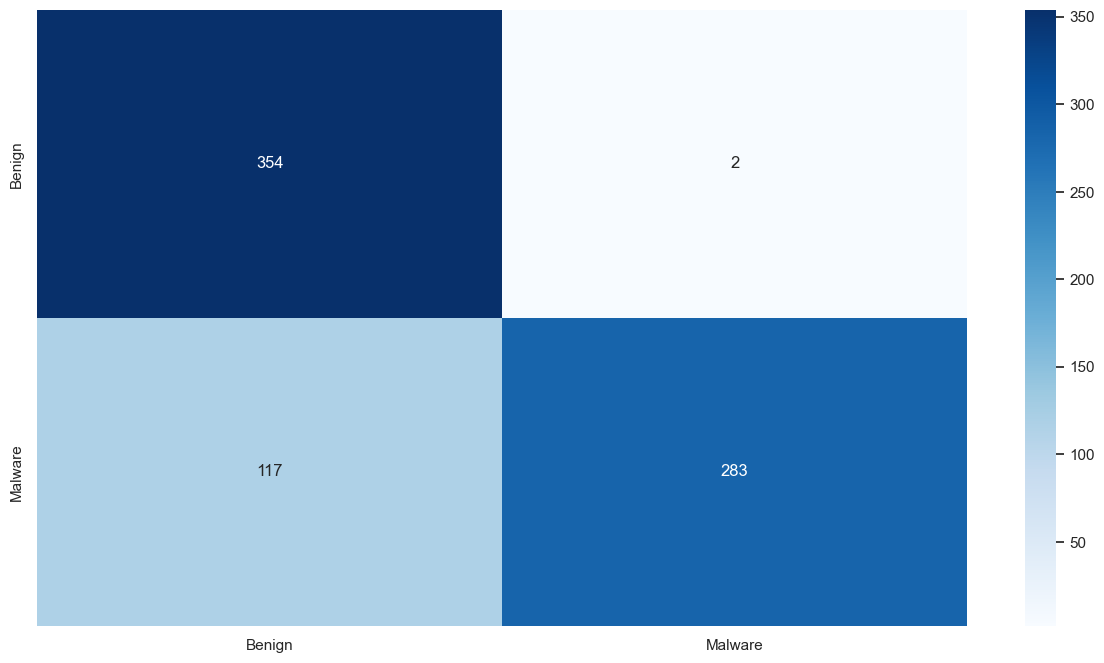

In [1639]:
model_report_presentation(mlp_gcv)

In [1640]:
# # Save the model
mlp = mlp_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/mlp"+str(dataset_number)+"_model.sav"
# pickle.dump(mlp, open(filename, 'wb'))

#### ExtraTreesClassifier


In [1641]:
etc = ExtraTreesClassifier()
etc_param = {
    "n_estimators": [300],
}
etc_gcv = create_grid_search(etc, etc_param)
etc_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [300]}, return_train_score=True,
             verbose=3)

In [1642]:
print("Best parameters:", etc_gcv.best_params_)

Best parameters: {'n_estimators': 300}


              precision    recall  f1-score   support

      Benign    0.76623   0.99438   0.86553       356
     Malware    0.99320   0.73000   0.84150       400

    accuracy                        0.85450       756
   macro avg    0.87972   0.86219   0.85351       756
weighted avg    0.88632   0.85450   0.85281       756



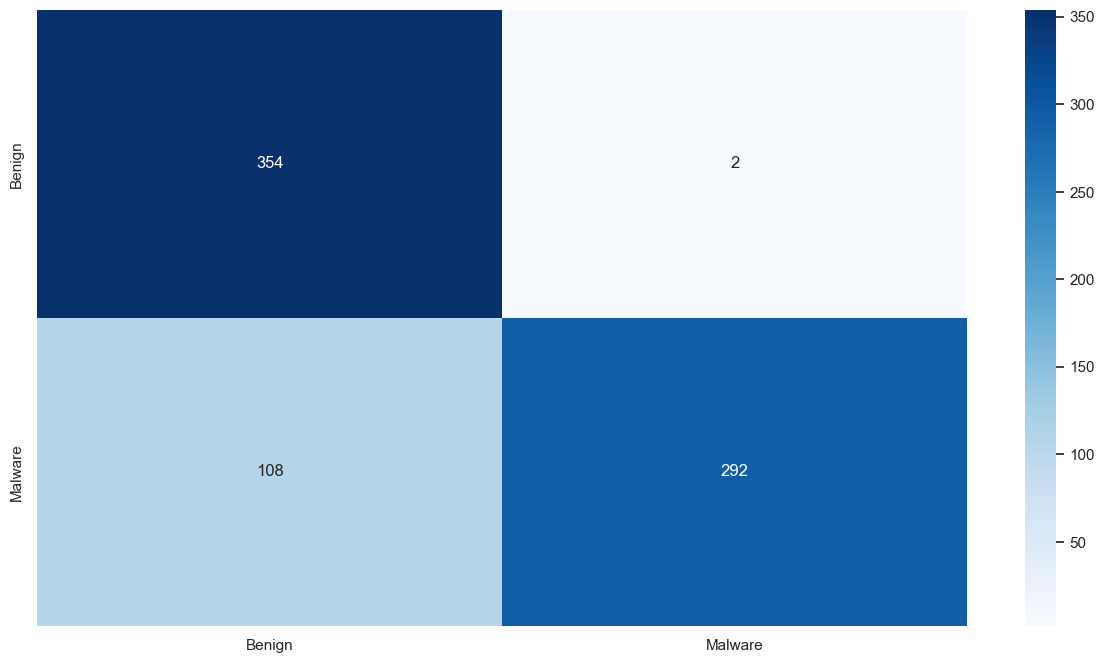

In [1643]:
model_report_presentation(etc_gcv)

In [1644]:
# # Save the model
etc = etc_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/abc"+str(dataset_number)+"_model.sav"
# pickle.dump(etc, open(filename, 'wb'))

#### Voting Classifier

Meta-classifier that combines the predictions of multiple classifiers.
It is a simple way to improve the performance of a model by combining the predictions of multiple models.


In [1645]:
vc = VotingClassifier(estimators=[("clf",clf),
                                  ("svc",svc),
                                  ("lr",lr),
                                  ("knn",knn),
                                  ("dt",dt),
                                  ("abc",abc),
                                  ("gbc",gbc),
                                  ("mlp",mlp),
                                  ("etc",etc)])
vc_param = {
    "weights": [[1,1,1,1,1,1,1,1,1],
                [2,1,1,1,1,1,1,1,1],
                [1,2,1,1,1,1,1,1,1],
                [1,1,2,1,1,1,1,1,1],
                [1,1,1,2,1,1,1,1,1],
                [1,1,1,1,3,1,1,1,1],
                [1,1,1,1,1,2,1,1,1],
                [1,1,1,1,1,1,2,1,1],
                [1,1,1,1,1,1,1,2,1],
                [1,1,1,1,1,1,2,1,2]],
    "voting": ["hard", "soft"],
}
vc_gcv = create_grid_search(vc, vc_param)
vc_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\moria\PycharmProjects\API_Security_Research\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('clf',
                                                     RandomForestClassifier(max_depth=5)),
                                                    ('svc',
                                                     SVC(C=2, cache_size=500,
                                                         probability=True)),
                                                    ('lr',
                                                     LogisticRegression(C=1,
                                                                        penalty='none')),
                                                    ('knn',
                                                     KNeighborsClassifier(n_neighbors=3,
                                                                          weights='distance')),
                                                    ('dt',
                                                     DecisionTreeClassifier(criterion='entropy',
                                                                            max_depth=9)),
                                                    ('abc',
                                                     AdaBoostClassifier(le...
                                                                   shuffle=False)),
                                                    ('etc',
                                                     ExtraTreesClassifier(n_estimators=300))]),
             n_jobs=-1,
             param_grid={'voting': ['hard', 'soft'],
                         'weights': [[1, 1, 1, 1, 1, 1, 1, 1, 1],
                                     [2, 1, 1, 1, 1, 1, 1, 1, 1],
                                     [1, 2, 1, 1, 1, 1, 1, 1, 1],
                                     [1, 1, 2, 1, 1, 1, 1, 1, 1],
                                     [1, 1, 1, 2, 1, 1, 1, 1, 1],
                                     [1, 1, 1, 1, 3, 1, 1, 1, 1],
                                     [1, 1, 1, 1, 1, 2, 1, 1, 1],
                                     [1, 1, 1, 1, 1, 1, 2, 1, 1],
                                     [1, 1, 1, 1, 1, 1, 1, 2, 1],
                                     [1, 1, 1, 1, 1, 1, 2, 1, 2]]},
             return_train_score=True, verbose=3)

In [1646]:
print("Best parameters:", vc_gcv.best_params_)

Best parameters: {'voting': 'soft', 'weights': [1, 1, 2, 1, 1, 1, 1, 1, 1]}


              precision    recall  f1-score   support

      Benign    0.81967   0.84270   0.83102       356
     Malware    0.85641   0.83500   0.84557       400

    accuracy                        0.83862       756
   macro avg    0.83804   0.83885   0.83830       756
weighted avg    0.83911   0.83862   0.83872       756



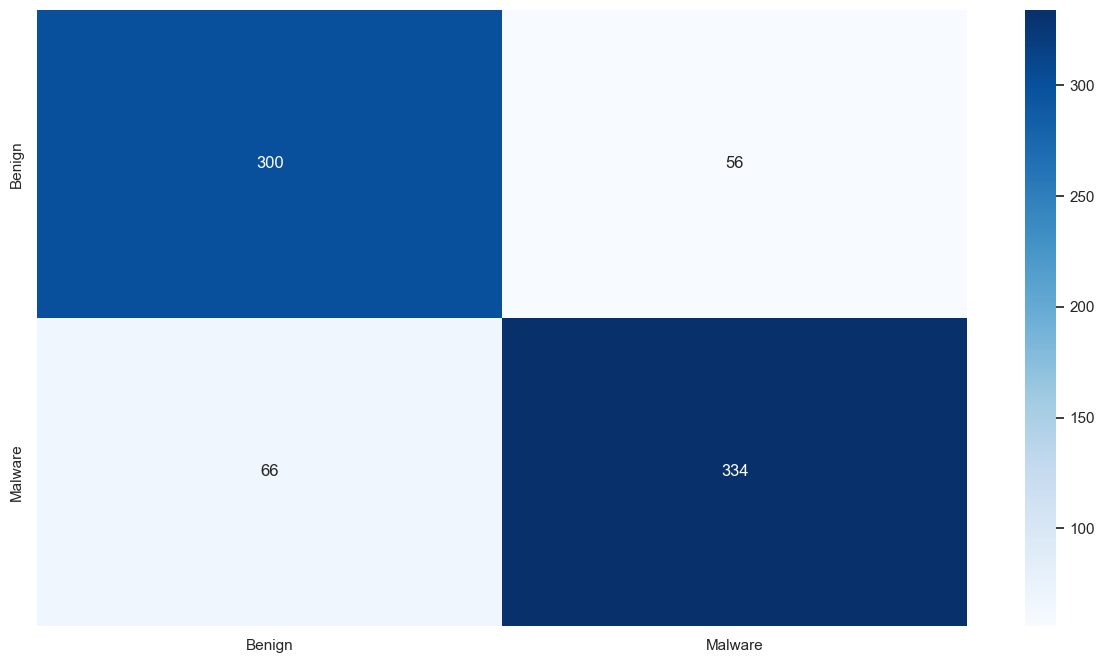

In [1647]:
model_report_presentation(vc_gcv)

In [1648]:
# # Save the model
vc = vc_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/vc"+str(dataset_number)+"_model.sav"
# pickle.dump(vc, open(filename, 'wb'))

#### Stacking Classifier

Meta-classifier that combines the predictions of multiple classifiers.
It is a simple way to improve the performance of a model by combining the predictions of multiple models.


In [1649]:
sc = StackingClassifier(estimators=[("clf",clf),
                                    ("svc",svc),
                                    ("lr",lr),
                                    ("knn",knn),
                                    ("dt",dt),
                                    ("abc",abc),
                                    ("gbc",gbc),
                                    ("mlp",mlp),
                                    ("etc",etc)],
                        final_estimator=LogisticRegression())
sc_param = {"final_estimator__C": [1, 2, 3],
            "cv": ["prefit", None]}
sc_gcv = create_grid_search(sc, sc_param)
sc_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\moria\PycharmProjects\API_Security_Research\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


9 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\moria\PycharmProjects\API_Security_Research\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moria\PycharmProjects\API_Security_Research\venv\lib\site-packages\sklearn\ensemble\_stacking.py", line 660, in fit
    return super().fit(X, y_encoded, sample_weight)
  File "C:\Users\moria\PycharmProjects\API_Security_Research

GridSearchCV(cv=3,
             estimator=StackingClassifier(estimators=[('clf',
                                                       RandomForestClassifier(max_depth=5)),
                                                      ('svc',
                                                       SVC(C=2, cache_size=500,
                                                           probability=True)),
                                                      ('lr',
                                                       LogisticRegression(C=1,
                                                                          penalty='none')),
                                                      ('knn',
                                                       KNeighborsClassifier(n_neighbors=3,
                                                                            weights='distance')),
                                                      ('dt',
                                                       DecisionTreeClassifier(criterion='entropy',
                                                                              max_depth=9)),
                                                      ('abc',
                                                       AdaBoostClassifier(...
                                                       GradientBoostingClassifier(n_estimators=5)),
                                                      ('mlp',
                                                       MLPClassifier(batch_size=50,
                                                                     early_stopping=True,
                                                                     hidden_layer_sizes=(10,
                                                                                         50,
                                                                                         100,
                                                                                         150,
                                                                                         200,
                                                                                         250,
                                                                                         200,
                                                                                         150,
                                                                                         100,
                                                                                         50,
                                                                                         10),
                                                                     shuffle=False)),
                                                      ('etc',
                                                       ExtraTreesClassifier(n_estimators=300))],
                                          final_estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'cv': ['prefit', None],
                         'final_estimator__C': [1, 2, 3]},
             return_train_score=True, verbose=3)

In [1650]:
print("Best parameters:", sc_gcv.best_params_)

Best parameters: {'cv': None, 'final_estimator__C': 2}


              precision    recall  f1-score   support

      Benign    0.77726   0.94101   0.85133       356
     Malware    0.93538   0.76000   0.83862       400

    accuracy                        0.84524       756
   macro avg    0.85632   0.85051   0.84498       756
weighted avg    0.86092   0.84524   0.84461       756



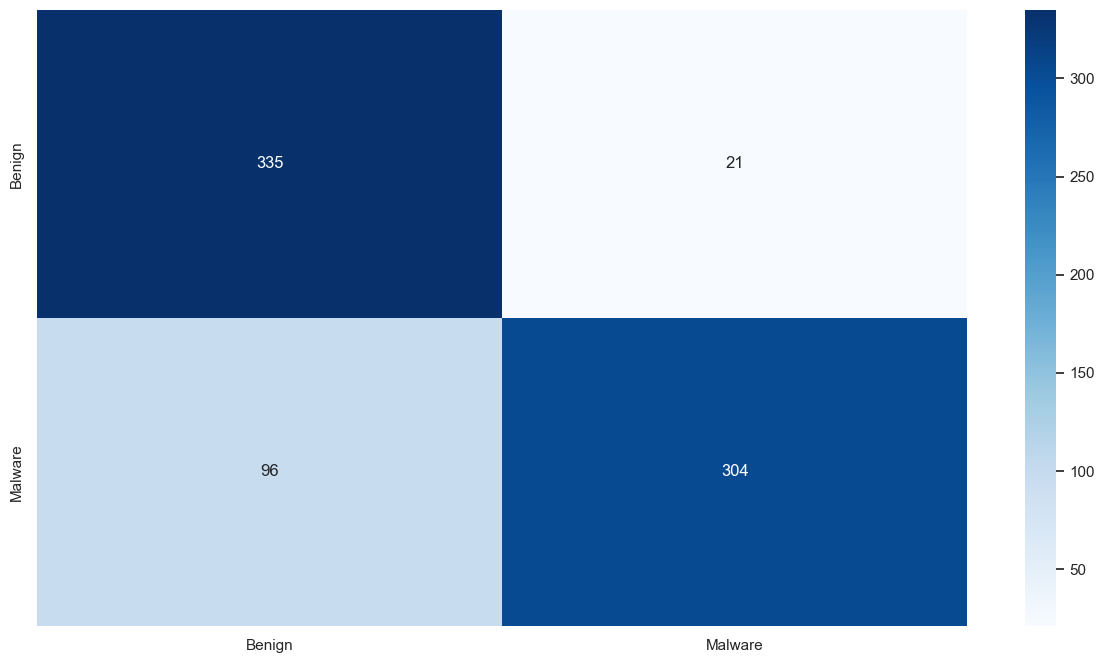

In [1651]:
model_report_presentation(sc_gcv)

In [1652]:
# # Save the model
sc = sc_gcv.best_estimator_
# filename = "Model/"+str(dataset_number)+"/sc"+str(dataset_number)+"_model.sav"
# pickle.dump(sc, open(filename, 'wb'))

### Choose The Best Model


In [1653]:
models = [clf, svc, lr, knn, dt, abc, gbc, mlp, vc, sc, etc]

model_names = ["Random Forest",
               "SVM",
               "Logistic Regression",
               "KNN",
               "Decision Tree",
               "AdaBoost",
               "Gradient Boosting",
               "Neural Network",
               "Voting Classifier",
               "Stacking Classifier",
               "Extra Trees"]

model_scores = []

for model in models:
    predictions = model.predict(x_test_pca)
    model_report = classification_report(y_test, predictions, digits=5)
    model_scores.append(model_report.split()[12])

#### Result


In [1654]:
best_model = models[model_scores.index(max(model_scores))]
best_model_name = model_names[model_scores.index(max(model_scores))]
best_model_score = max(model_scores)

print("Best model:", best_model_name)
print("Score:", str(best_model_score))

model_report = classification_report(y_test, predictions, digits=5)
print(model_report)

Best model: KNN
Score: 0.84863
              precision    recall  f1-score   support

      Benign    0.76623   0.99438   0.86553       356
     Malware    0.99320   0.73000   0.84150       400

    accuracy                        0.85450       756
   macro avg    0.87972   0.86219   0.85351       756
weighted avg    0.88632   0.85450   0.85281       756



## Test


In [1655]:
# Read the valuation json

with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

In [1656]:
# Preprocess data

# Replace NAN values
for column in test_df.columns[test_df.isna().any()].tolist():
    test_df[column] = test_df[column].fillna('None')

test_df = vector_df(test_df)

test_df.head()

1 request.headers.Accept-Encoding
1 request.method
1 request.headers.Accept-Language
1 request.headers.Sec-Fetch-Site
1 request.headers.Sec-Fetch-Mode
1 request.headers.Sec-Fetch-Dest
1 response.status
2 request.headers.User-Agent
2 request.headers.Set-Cookie
2 request.headers.Date
2 request.url
2 response.headers.Content-Type
2 response.body
3 request.body
3 response.headers.Content-Length
3 request.headers.Date
3 request.headers.Accept
3 request.headers.Connection
3 request.headers.Sec-Fetch-User
3 request.headers.Cookie
3 response.headers.Location
3 request.headers.Content-Length
3 response.headers.Set-Cookie
3 request.headers.Host


,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body
0,0.000000,0,0,0,0,0,-0.359211,0,-0.377964,4,-0.5,404,-0.127000
1,0.000000,0,0,0,0,0,0.000000,0,0.000000,4,0.0,404,0.000000
2,0.000000,0,1,0,1,0,-0.548821,0,0.000000,4,0.0,404,0.000000
3,0.229416,0,3,0,0,0,-0.363803,0,0.000000,4,0.0,404,0.000000
4,0.377964,0,0,0,1,0,-0.311086,0,0.000000,0,-0.5,200,-0.081379


In [1657]:
# Run the model

x = test_df[features_list].to_numpy()
x = ss.transform(x)
x = rfecv.transform(x)
pred_ = vc.predict(x)

C:\Users\moria\PycharmProjects\API_Security_Research\venv\lib\site-packages\sklearn\base.py:409: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [1658]:
# Save your predictions

enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt',
           enc.fit_transform(pred_), fmt='%2d')